In [9]:
import numpy as np
import pandas as pd
import pymc3 as pm
import theano
import theano.tensor as tt
import copy
import feather
import re

import matplotlib.pyplot as plt
import statsmodels.stats.stattools

%matplotlib inline

In [40]:
def get_logfcs_comparison(df, type1, type2):
    type2 = re.sub("[ \+]", ".", type2)
    return(np.array(df[df.cluster == type1]["logFC." + type2]))

def plot_posterior_predictive(ppc, fun1 = lambda x: np.mean(x, axis = 1), 
                              fun2 = lambda x: np.mean(x),
                              xlab = "mean(x)",
                             title = "Posterior predictive of mean"):
    _, ax = plt.subplots(figsize=(12, 6))
    ax.hist(fun1(ppc['obs']), bins=20, alpha=0.5)
    ax.axvline(fun2(observations))
    ax.set(title=title, xlabel=xlab, ylabel='Frequency');

In [3]:
sce_markers = feather.read_dataframe('/datadrive/projects/cellassign-analysis/temp/pbmc68k_markers.feather')
sce_null_logfcs = feather.read_dataframe('/datadrive/projects/cellassign-analysis/temp/pbmc_68k_normal_logfcs.feather')

In [6]:
class1 = "Naive CD8+"
class2 = "Naive CD4+"

logfcs_diff = get_logfcs_comparison(sce_markers, class1, class2)
logfcs_same = np.array(sce_null_logfcs[(sce_null_logfcs['celltype'] == class2) & (sce_null_logfcs['permutation'] == 1)].logfc)

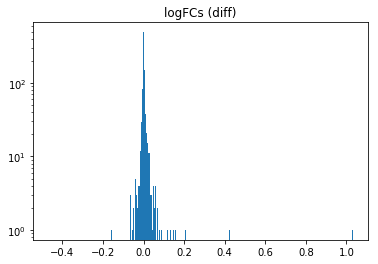

In [31]:
plt.hist(logfcs_diff, bins = 'auto') 
plt.title("logFCs (diff)")
plt.yscale('log', nonposy='clip')
plt.show()

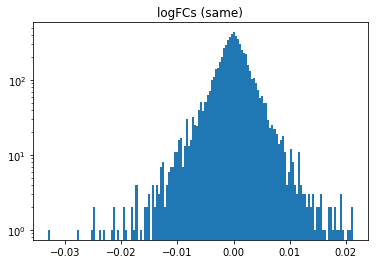

In [32]:
plt.hist(logfcs_same, bins = 'auto') 
plt.title("logFCs (same)")
plt.yscale('log', nonposy='clip')
plt.show()

In [ ]:
iter_count = 2000
tune_iters = 2000

observations = logfcs_diff
nulls = logfcs_same

with pm.Model() as model:
    # Probability of being a DE gene
    de_prob = pm.Uniform('de_prob', lower = 0., upper = 1.)
    
    # Probability of being downregulated
    down_prob = pm.Beta('down_prob', alpha = 1., beta = 1.)
    
    # Mean and sd for Gaussian for non-DE genes (learned from bootstrap resampling)
    mu_null = pm.Gamma('mu_null', alpha = 1., beta = 1.)
    sd_null = pm.Gamma('sd_null', alpha = 1., beta = 1.)
    
    # Mean and sd for Gaussian for DE genes
    mu_pos = pm.Lognormal('mu_pos', mu = 0., sd = 1.)
    mu_neg = pm.Lognormal('mu_neg', mu = 0., sd = 1.)
    
    sd = pm.Gamma('sd', alpha = 1., beta = 1.)
    
    # Sample from Gaussian for null
    pm.Normal('null',
             mu = mu_null,
             sd = sd_null,
             observed = nulls)
    
    null_component = pm.Normal.dist(mu = mu_null,
                                  sd = sd_null)
    
    pos_component = pm.Bound(pm.Normal, lower=0.).dist(mu=mu_pos, sd=sd)
    neg_component = pm.Bound(pm.Normal, upper=0.).dist(mu=-1*mu_neg, sd=sd)

    pm.Mixture('obs',
              w = tt.as_tensor([(1-de_prob), de_prob * (1-down_prob), de_prob * down_prob]),
              comp_dists = [null_component, pos_component, neg_component],
              observed = observations)
    
    pm.Deterministic('log_prob', model.logpt)

    trace = pm.sample(iter_count, tune = tune_iters, chains = 4)
    ppc = pm.sample_ppc(trace, samples=2000, model=model)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f53120a8668>,
      dtype=object)

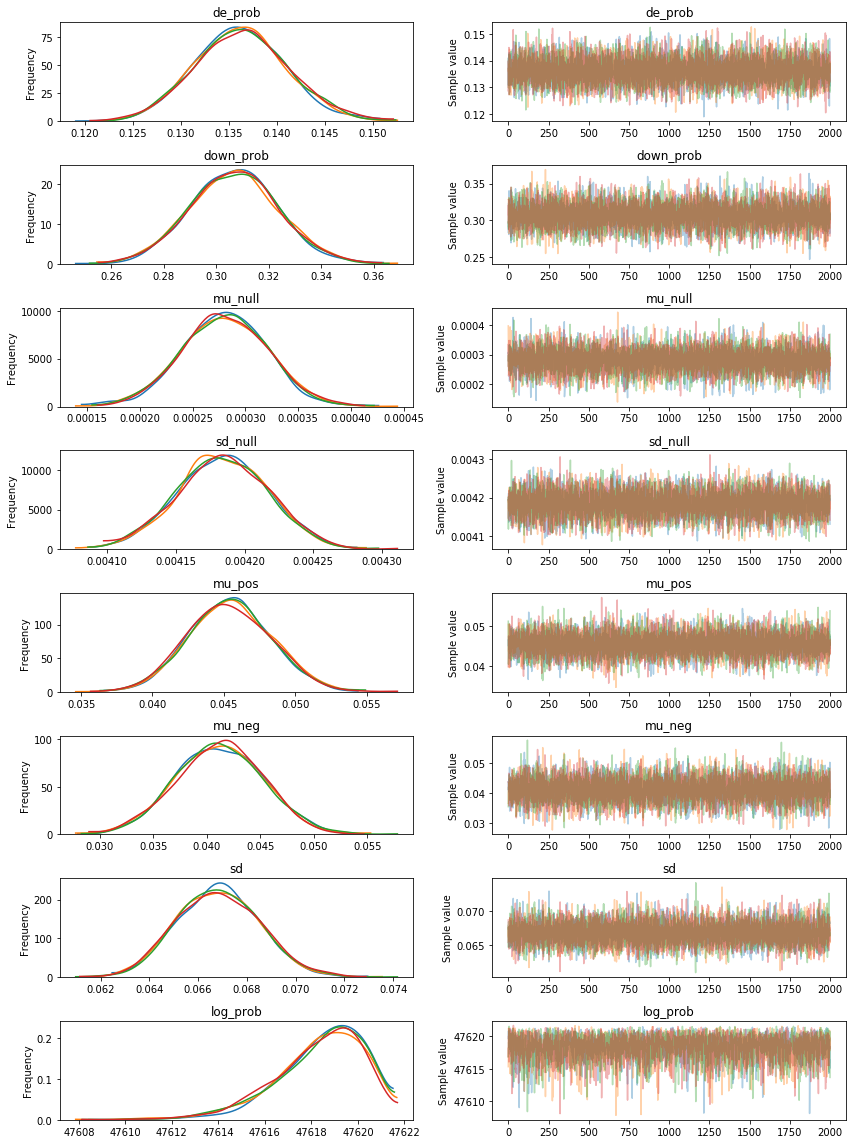

In [38]:
pm.plots.traceplot(trace)

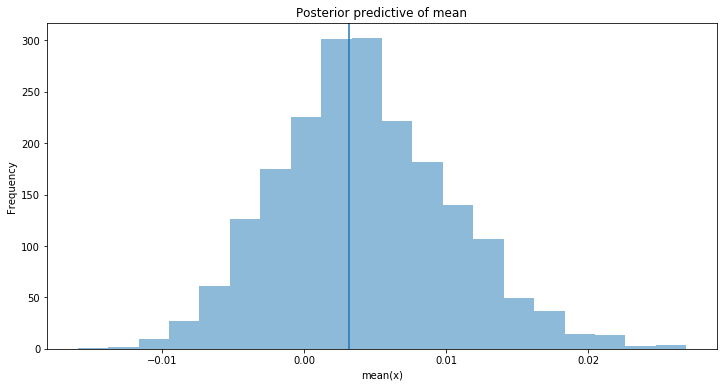

In [41]:
plot_posterior_predictive(ppc, fun1 = lambda x: np.mean(x, axis = 1), 
                          fun2 = lambda x: np.mean(x), 
                          xlab = "mean(x)",
                          title = "Posterior predictive of mean")

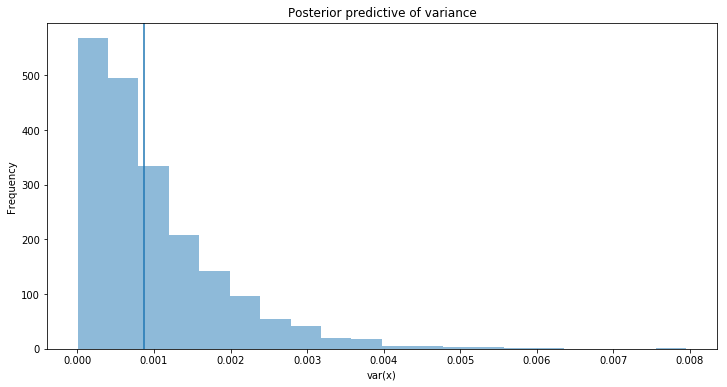

In [42]:
plot_posterior_predictive(ppc, fun1 = lambda x: np.var(x, axis = 1), 
                          fun2 = lambda x: np.var(x), 
                          xlab = "var(x)",
                          title = "Posterior predictive of variance")

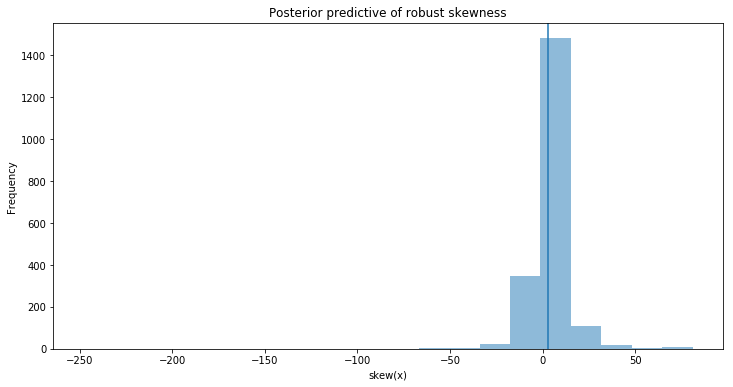

In [43]:
plot_posterior_predictive(ppc, fun1 = lambda x: statsmodels.stats.stattools.robust_skewness(x, axis = 1)[3], 
                          fun2 = lambda x: statsmodels.stats.stattools.robust_skewness(x)[3], 
                          xlab = "skew(x)",
                          title = "Posterior predictive of robust skewness")